In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Loading the Dataset

In [3]:
data = pd.read_csv('house_prices.csv')
data.head()

,Index,Title,Description,Amount(in rupees),Price (in rupees),location,Carpet Area,Status,Floor,Transaction,...,facing,overlooking,Society,Bathroom,Balcony,Car Parking,Ownership,Super Area,Dimensions,Plot Area
0,0,1 BHK Ready to Occupy Flat for sale in Srushti...,"Bhiwandi, Thane has an attractive 1 BHK Flat f...",42 Lac,6000.0,thane,500 sqft,Ready to Move,10 out of 11,Resale,...,NaN,NaN,Srushti Siddhi Mangal Murti Complex,1,2,NaN,NaN,NaN,NaN,NaN
1,1,2 BHK Ready to Occupy Flat for sale in Dosti V...,One can find this stunning 2 BHK flat for sale...,98 Lac,13799.0,thane,473 sqft,Ready to Move,3 out of 22,Resale,...,East,Garden/Park,Dosti Vihar,2,NaN,1 Open,Freehold,NaN,NaN,NaN
2,2,2 BHK Ready to Occupy Flat for sale in Sunrise...,Up for immediate sale is a 2 BHK apartment in ...,1.40 Cr,17500.0,thane,779 sqft,Ready to Move,10 out of 29,Resale,...,East,Garden/Park,Sunrise by Kalpataru,2,NaN,1 Covered,Freehold,NaN,NaN,NaN
3,3,1 BHK Ready to Occupy Flat for sale Kasheli,This beautiful 1 BHK Flat is available for sal...,25 Lac,NaN,thane,530 sqft,Ready to Move,1 out of 3,Resale,...,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN
4,4,2 BHK Ready to Occupy Flat for sale in TenX Ha...,"This lovely 2 BHK Flat in Pokhran Road, Thane ...",1.60 Cr,18824.0,thane,635 sqft,Ready to Move,20 out of 42,Resale,...,West,"Garden/Park, Main Road",TenX Habitat Raymond Realty,2,NaN,1 Covered,Co-operative Society,NaN,NaN,NaN


### **EDA**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187531 entries, 0 to 187530
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Index              187531 non-null  int64  
 1   Title              187531 non-null  object 
 2   Description        184508 non-null  object 
 3   Amount(in rupees)  187531 non-null  object 
 4   Price (in rupees)  169866 non-null  float64
 5   location           187531 non-null  object 
 6   Carpet Area        106858 non-null  object 
 7   Status             186916 non-null  object 
 8   Floor              180454 non-null  object 
 9   Transaction        187448 non-null  object 
 10  Furnishing         184634 non-null  object 
 11  facing             117298 non-null  object 
 12  overlooking        106095 non-null  object 
 13  Society            77853 non-null   object 
 14  Bathroom           186703 non-null  object 
 15  Balcony            138596 non-null  object 
 16  Ca

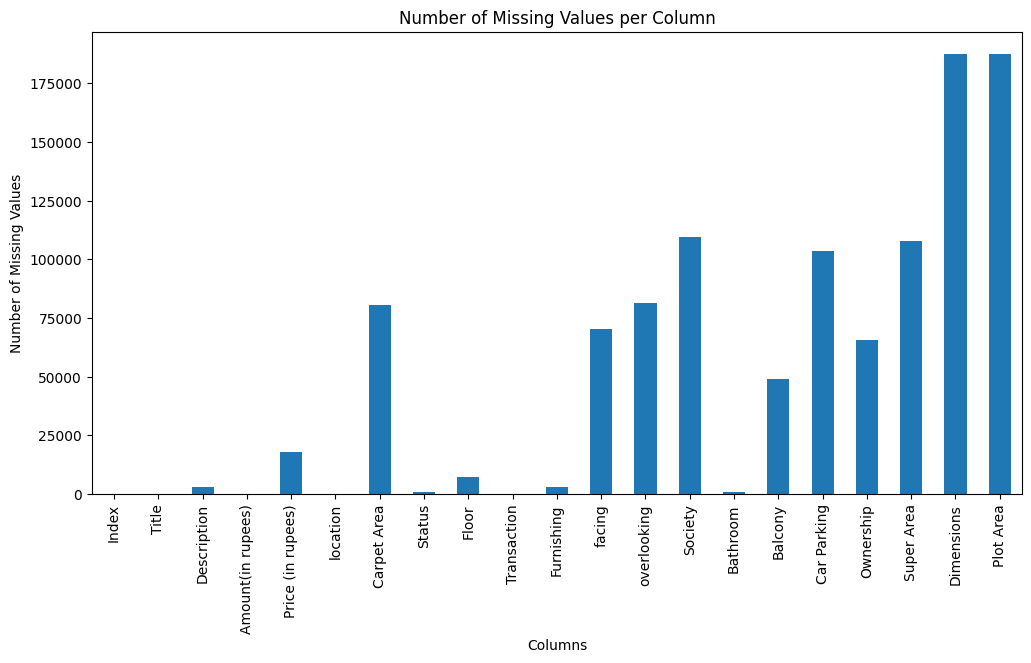

In [4]:
# Check the data types and missing values
print(data.info())

# Plotting the number of missing values per column
plt.figure(figsize=(12, 6))
data.isnull().sum().plot(kind='bar')
plt.title('Number of Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.show()

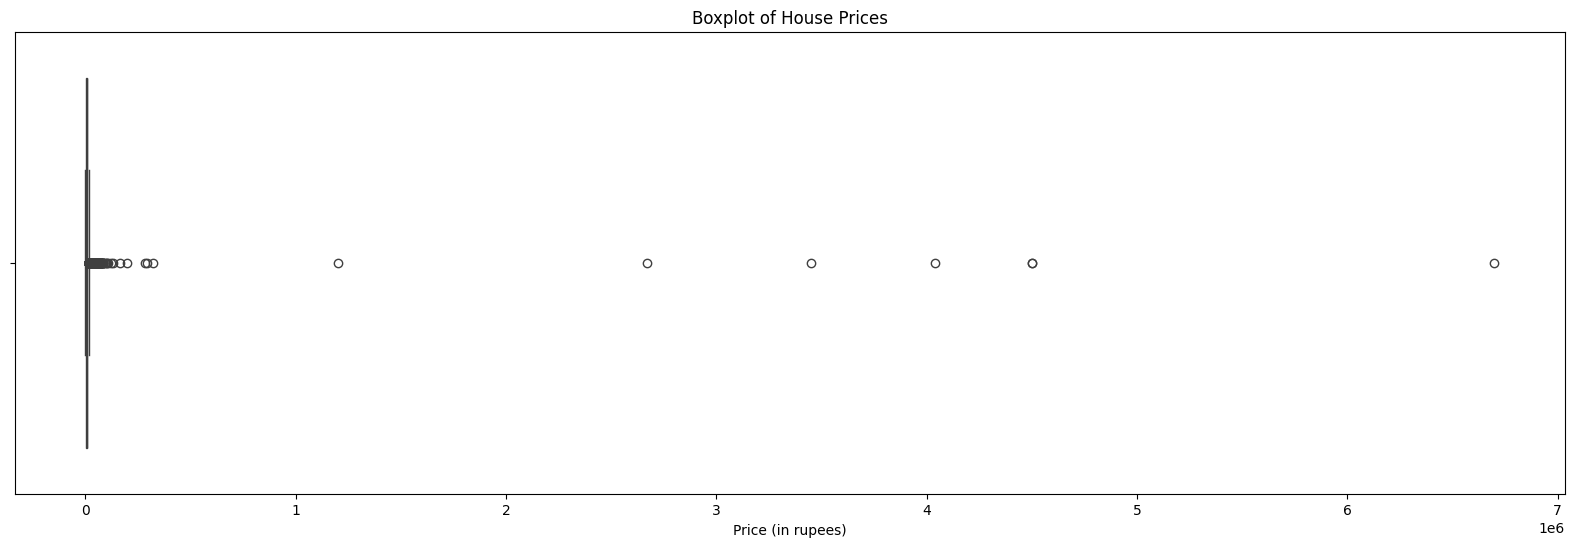

In [5]:
plt.figure(figsize=(20, 6))
sns.boxplot(x=data['Price (in rupees)'])
plt.title('Boxplot of House Prices')
plt.xlabel('Price (in rupees)')
plt.show()

### **PREPROCESSING/EXTRACTING VALUES**

In [6]:
# Removing all houses with unknown prices, because it is the main information
data = data.dropna(subset=["Price (in rupees)"])

# Extracting how many bedrooms there are from "Title"
data["Bedroom"] = (
    data["Title"]
    .str.extract(r"(\d+)\s*BHK", expand=False)
    .replace({"Studio": 1, "Apartment": 1, "Builder Floor": 1, "> 10": 11})
    .fillna(1)
    .astype(int)
)

# Converting "Amount(in rupees)" to numbers
data["Crore"] = data["Amount(in rupees)"].str.contains("Cr").astype(int)
data.loc[data["Crore"] == 1, "Amount(in rupees)"] = (data.loc[data["Crore"] == 1, "Amount(in rupees)"].str[:-3].astype(float) * 100)
data.loc[data["Crore"] == 0, "Amount(in rupees)"] = (data.loc[data["Crore"] == 0, "Amount(in rupees)"].str[:-4].astype(float))

# Converting "Carpet Area" and "Super Area" to numbers
data = data[data["Carpet Area"].fillna("0 sqft").str.endswith("sqft")]
data["Carpet Area"] = data["Carpet Area"].str[:-4].astype(float)

data = data[data["Super Area"].fillna("0 sqft").str.endswith("sqft")]
data["Super Area"] = data["Super Area"].str.replace(",", "").str[:-4].astype(float)

# Extracting current and max floor from "Floor"
data["Floor"] = data["Floor"].replace(
    {"Upper Basement": "0", "Lower Basement": "0", "Ground": "1"}
)
data["Max_floor"] = data["Floor"].str.extract(r"(\d+)$").astype(float)
data["Floor"] = data["Floor"].str.extract(r"^(\d+)").astype(float)

# Converting "Balcony" and "Bathroom" to numbers
data[["Balcony", "Bathroom"]] = data[["Balcony", "Bathroom"]].fillna("0")
data["Balcony"] = data["Balcony"].str.replace("> 10", "11")
data["Bathroom"] = data["Bathroom"].str.replace("> 10", "11")

#### Label and OneHot Encoding

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

OHE=OneHotEncoder(handle_unknown='ignore',sparse_output=False, dtype=int).set_output(transform='pandas')
LE=LabelEncoder()

# Label-encoding "Furnishing", "Transaction" and "Status"
data = data[data['Transaction'] != 'Rent/Lease']  # Removing 'Rent/Lease' values
data['Furnishing'].replace({'Unfurnished': 0, 'Semi-Furnished': 1, 'Furnished': 2}, inplace=True)  # Label-Encoding for Furnishing
data['Transaction'].replace({'Other': 0, 'Resale': 1, 'New Property': 2}, inplace=True)  # Label-Encoding for Transaction
data['Status'] = LE.fit_transform(data['Status'])  # Label-Encoding for Status

# One-hot encoding house overlooking
data['overlooking'] = data['overlooking'].fillna(' ')  # Filling missing values with blank spaces
data['Overlooking_Garden/Park'] = data['overlooking'].str.contains('Garden/Park').astype(int)  # Deciding if house overlooks garden/park
data['Overlooking_Main_Road'] = data['overlooking'].str.contains('Main Road').astype(int)  # Deciding if house overlooks main road
data['Overlooking_Pool'] = data['overlooking'].str.contains('Pool').astype(int)  # Deciding if house overlooks pool

# One-hot encoding house facing
data['facing'] = data['facing'].fillna(' ')  # Filling missing values with blank spaces
data['Facing_North'] = data['facing'].str.contains('North').astype(int)  # Deciding if house is facing north
data['Facing_East'] = data['facing'].str.contains('East').astype(int)  # Deciding if house is facing east
data['Facing_South'] = data['facing'].str.contains('South').astype(int)  # Deciding if house is facing south
data['Facing_West'] = data['facing'].str.contains('West').astype(int)  # Deciding if house is facing west

# One-hot encoding house ownership
ohe_transform = OHE.fit_transform(data[['Ownership']].fillna('no_information'))  # One-hot encoding on 'Ownership'
data = pd.concat([data, ohe_transform], axis=1).drop(columns=['Ownership'])

C:\Users\Dell\AppData\Local\Temp\ipykernel_8116\1468821785.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Furnishing'].replace({'Unfurnished': 0, 'Semi-Furnished': 1, 'Furnished': 2}, inplace=True)  # Label-Encoding for Furnishing
C:\Users\Dell\AppData\Local\Temp\ipykernel_8116\1468821785.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd

In [8]:
#Dropping columns and changing data types
data[['Bathroom','Balcony','Amount(in rupees)']]=data[['Bathroom','Balcony','Amount(in rupees)']].astype(float) #converting all non-binary and non-label columns to float
data[['Furnishing','Transaction']]=data[['Furnishing','Transaction']].fillna('0').astype(int)
data.drop(['Title','Index','Society','Car Parking','overlooking','Crore','facing','Description', 'Plot Area', 'Dimensions', 'Amount(in rupees)'], axis=1, inplace=True) #dropping unique or unused columns
data.rename(columns = { 'Price (in rupees)': 'Price_in_rupees', 'Carpet Area': 'Carpet_area', 'Super Area': 'Super_area'}, inplace = True) #renaming columns

#dropping rows where price_in_rupees is 0
data = data[data['Price_in_rupees'] != 0]

#### Handling **NULL** Values

In [9]:
# Fill missing values with the median and mean
data["Carpet_area"].fillna(data["Carpet_area"].median(), inplace=True)
data["Super_area"].fillna(data["Super_area"].median(), inplace=True)
data["Floor"].fillna(data["Floor"].mean().round().astype(int), inplace=True)
data["Max_floor"].fillna(data["Max_floor"].mean().round().astype(int), inplace=True)

C:\Users\Dell\AppData\Local\Temp\ipykernel_8116\1073264157.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Carpet_area"].fillna(data["Carpet_area"].median(), inplace=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_8116\1073264157.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

### Handling Outliers

In [10]:
print(data.shape)
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = data['Price_in_rupees'].quantile(0.25)
Q3 = data['Price_in_rupees'].quantile(0.75)

# Calculate the IQR
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the data to remove outliers
data = data[(data['Price_in_rupees'] >= lower_bound) & (data['Price_in_rupees'] <= upper_bound)]

print(f"Data shape after removing outliers: {data.shape}")

(160240, 24)
Data shape after removing outliers: (152449, 24)


### **Final Pre-Processed Clean Data**

In [11]:
print(data.shape) #displaying the cleaned data
data.to_csv('cleaned_house_prices.csv', index=False) #saving the cleaned data to a csv file

(152449, 24)


#### Seperating Columns

In [12]:
numerical_columns = [
    "Price_in_rupees",
    "Carpet_area",
    "Floor",
    "Bathroom",
    "Balcony",
    "Super_area",
    "Max_floor",
]


categorical_columns = [
    "location",
    "Status",
    "Transaction",
    "Furnishing",
    "Bedroom",
    "Overlooking_Garden/Park",
    "Overlooking_Main_Road",
    "Overlooking_Pool",
    "Facing_North",
    "Facing_East",
    "Facing_South",
    "Facing_West",
    "Ownership_Co-operative Society",
    "Ownership_Freehold",
    "Ownership_Leasehold",
    "Ownership_Power Of Attorney",
    "Ownership_no_information",
]

### 

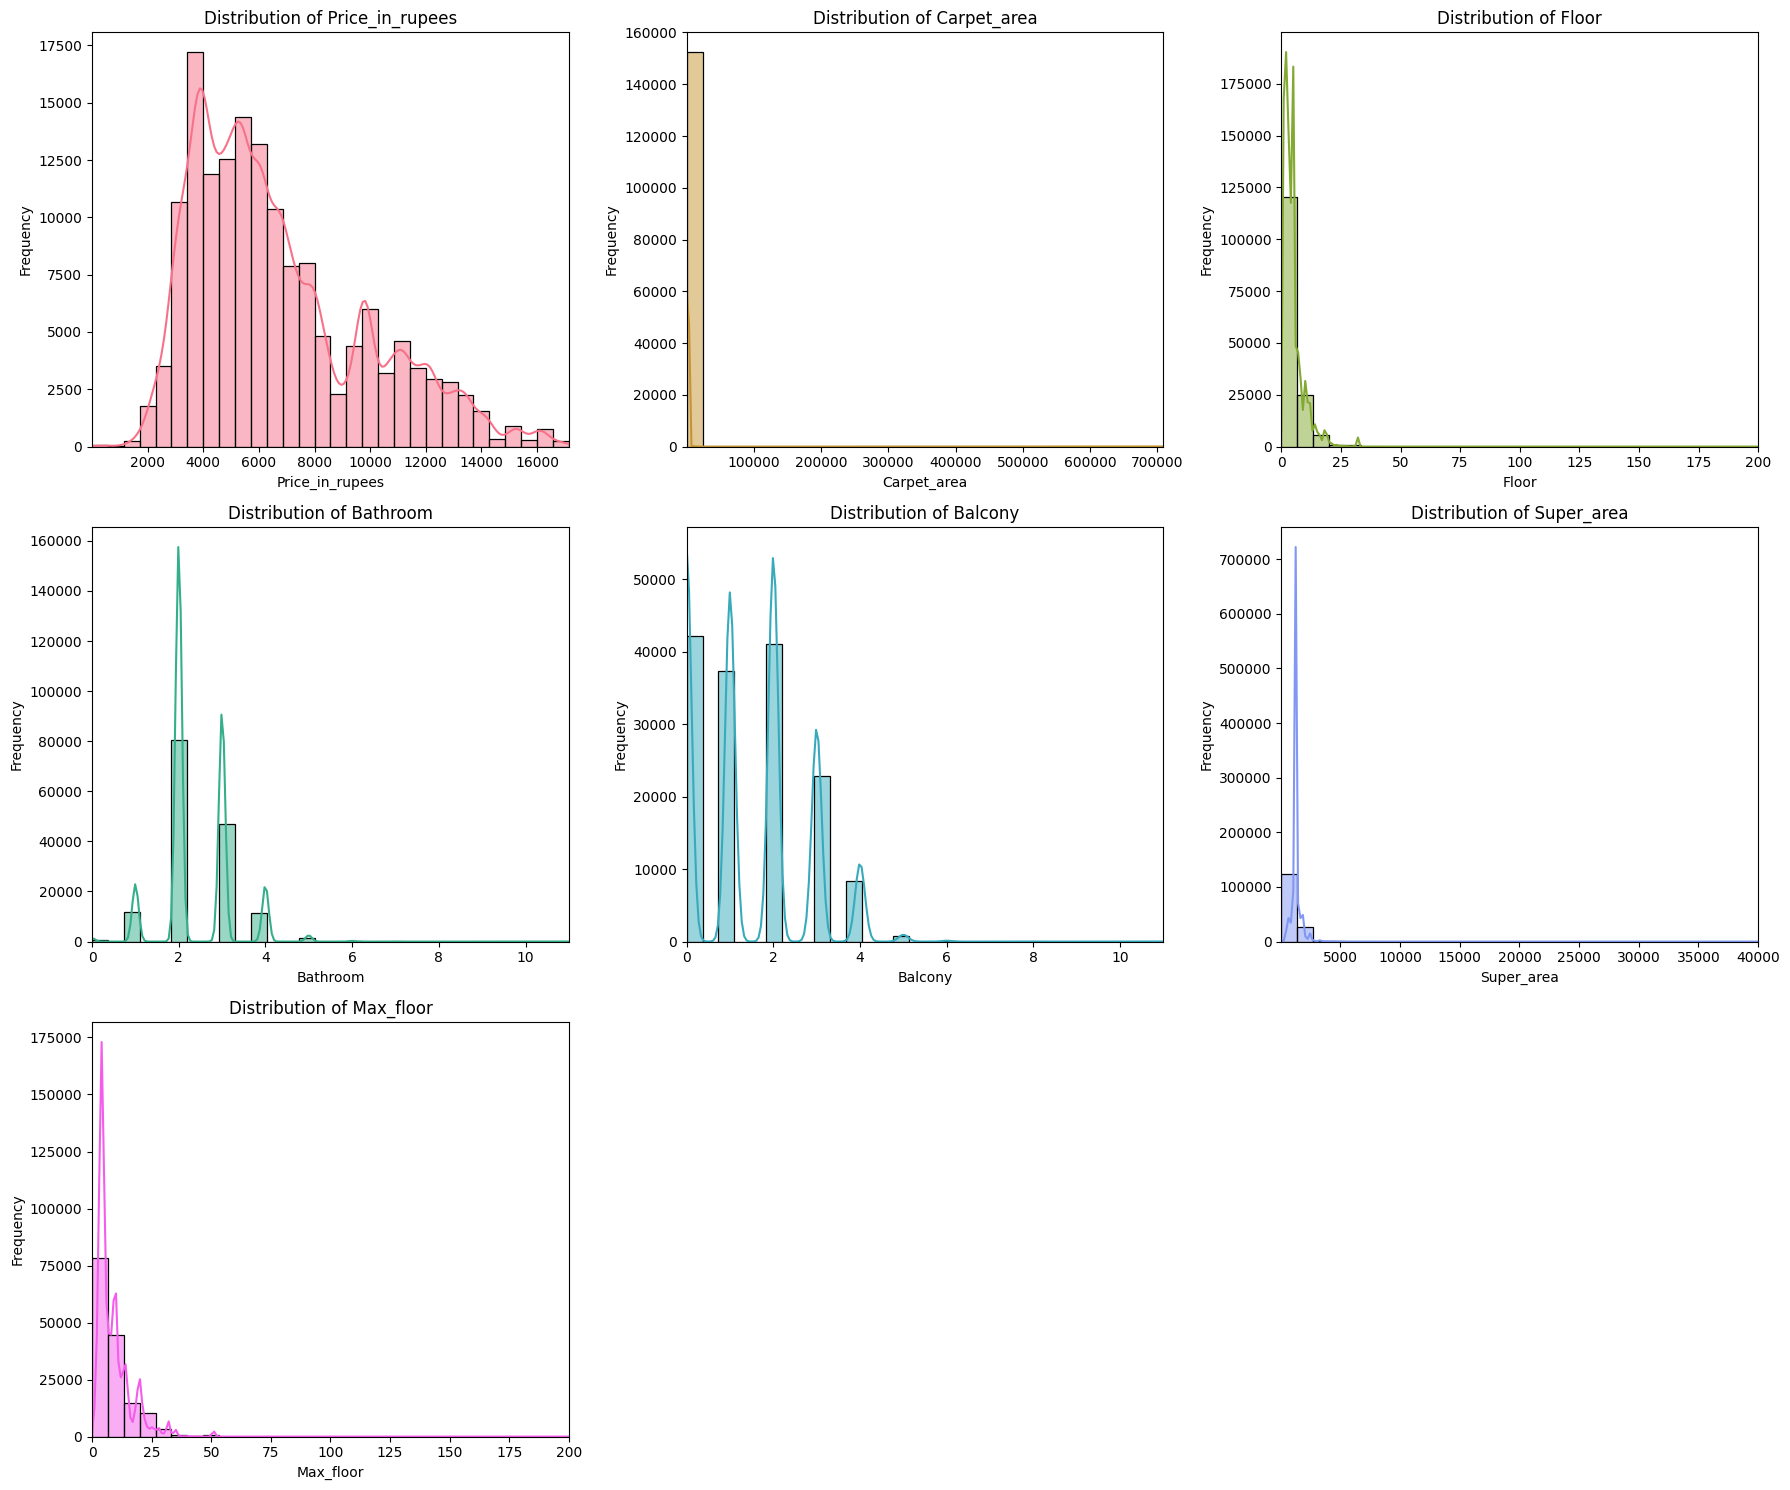

In [13]:
# Plot histograms for numerical features in a matrix
num_cols = len(numerical_columns)
num_rows = (num_cols // 3) + (num_cols % 3 > 0)
fig, axes = plt.subplots(num_rows, 3, figsize=(18, 5 * num_rows))
axes = axes.flatten()

colors = sns.color_palette("husl", num_cols)

for i, column in enumerate(numerical_columns):
    ax = axes[i]
    sns.histplot(data[column], bins=30, kde=True, color=colors[i], ax=ax)
    
    ax.set_xlim(data[column].min(), data[column].max())
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_8116\2869858189.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_loc.set_xticklabels(ax_loc.get_xticklabels(), rotation=90)  # Rotate x-axis labels


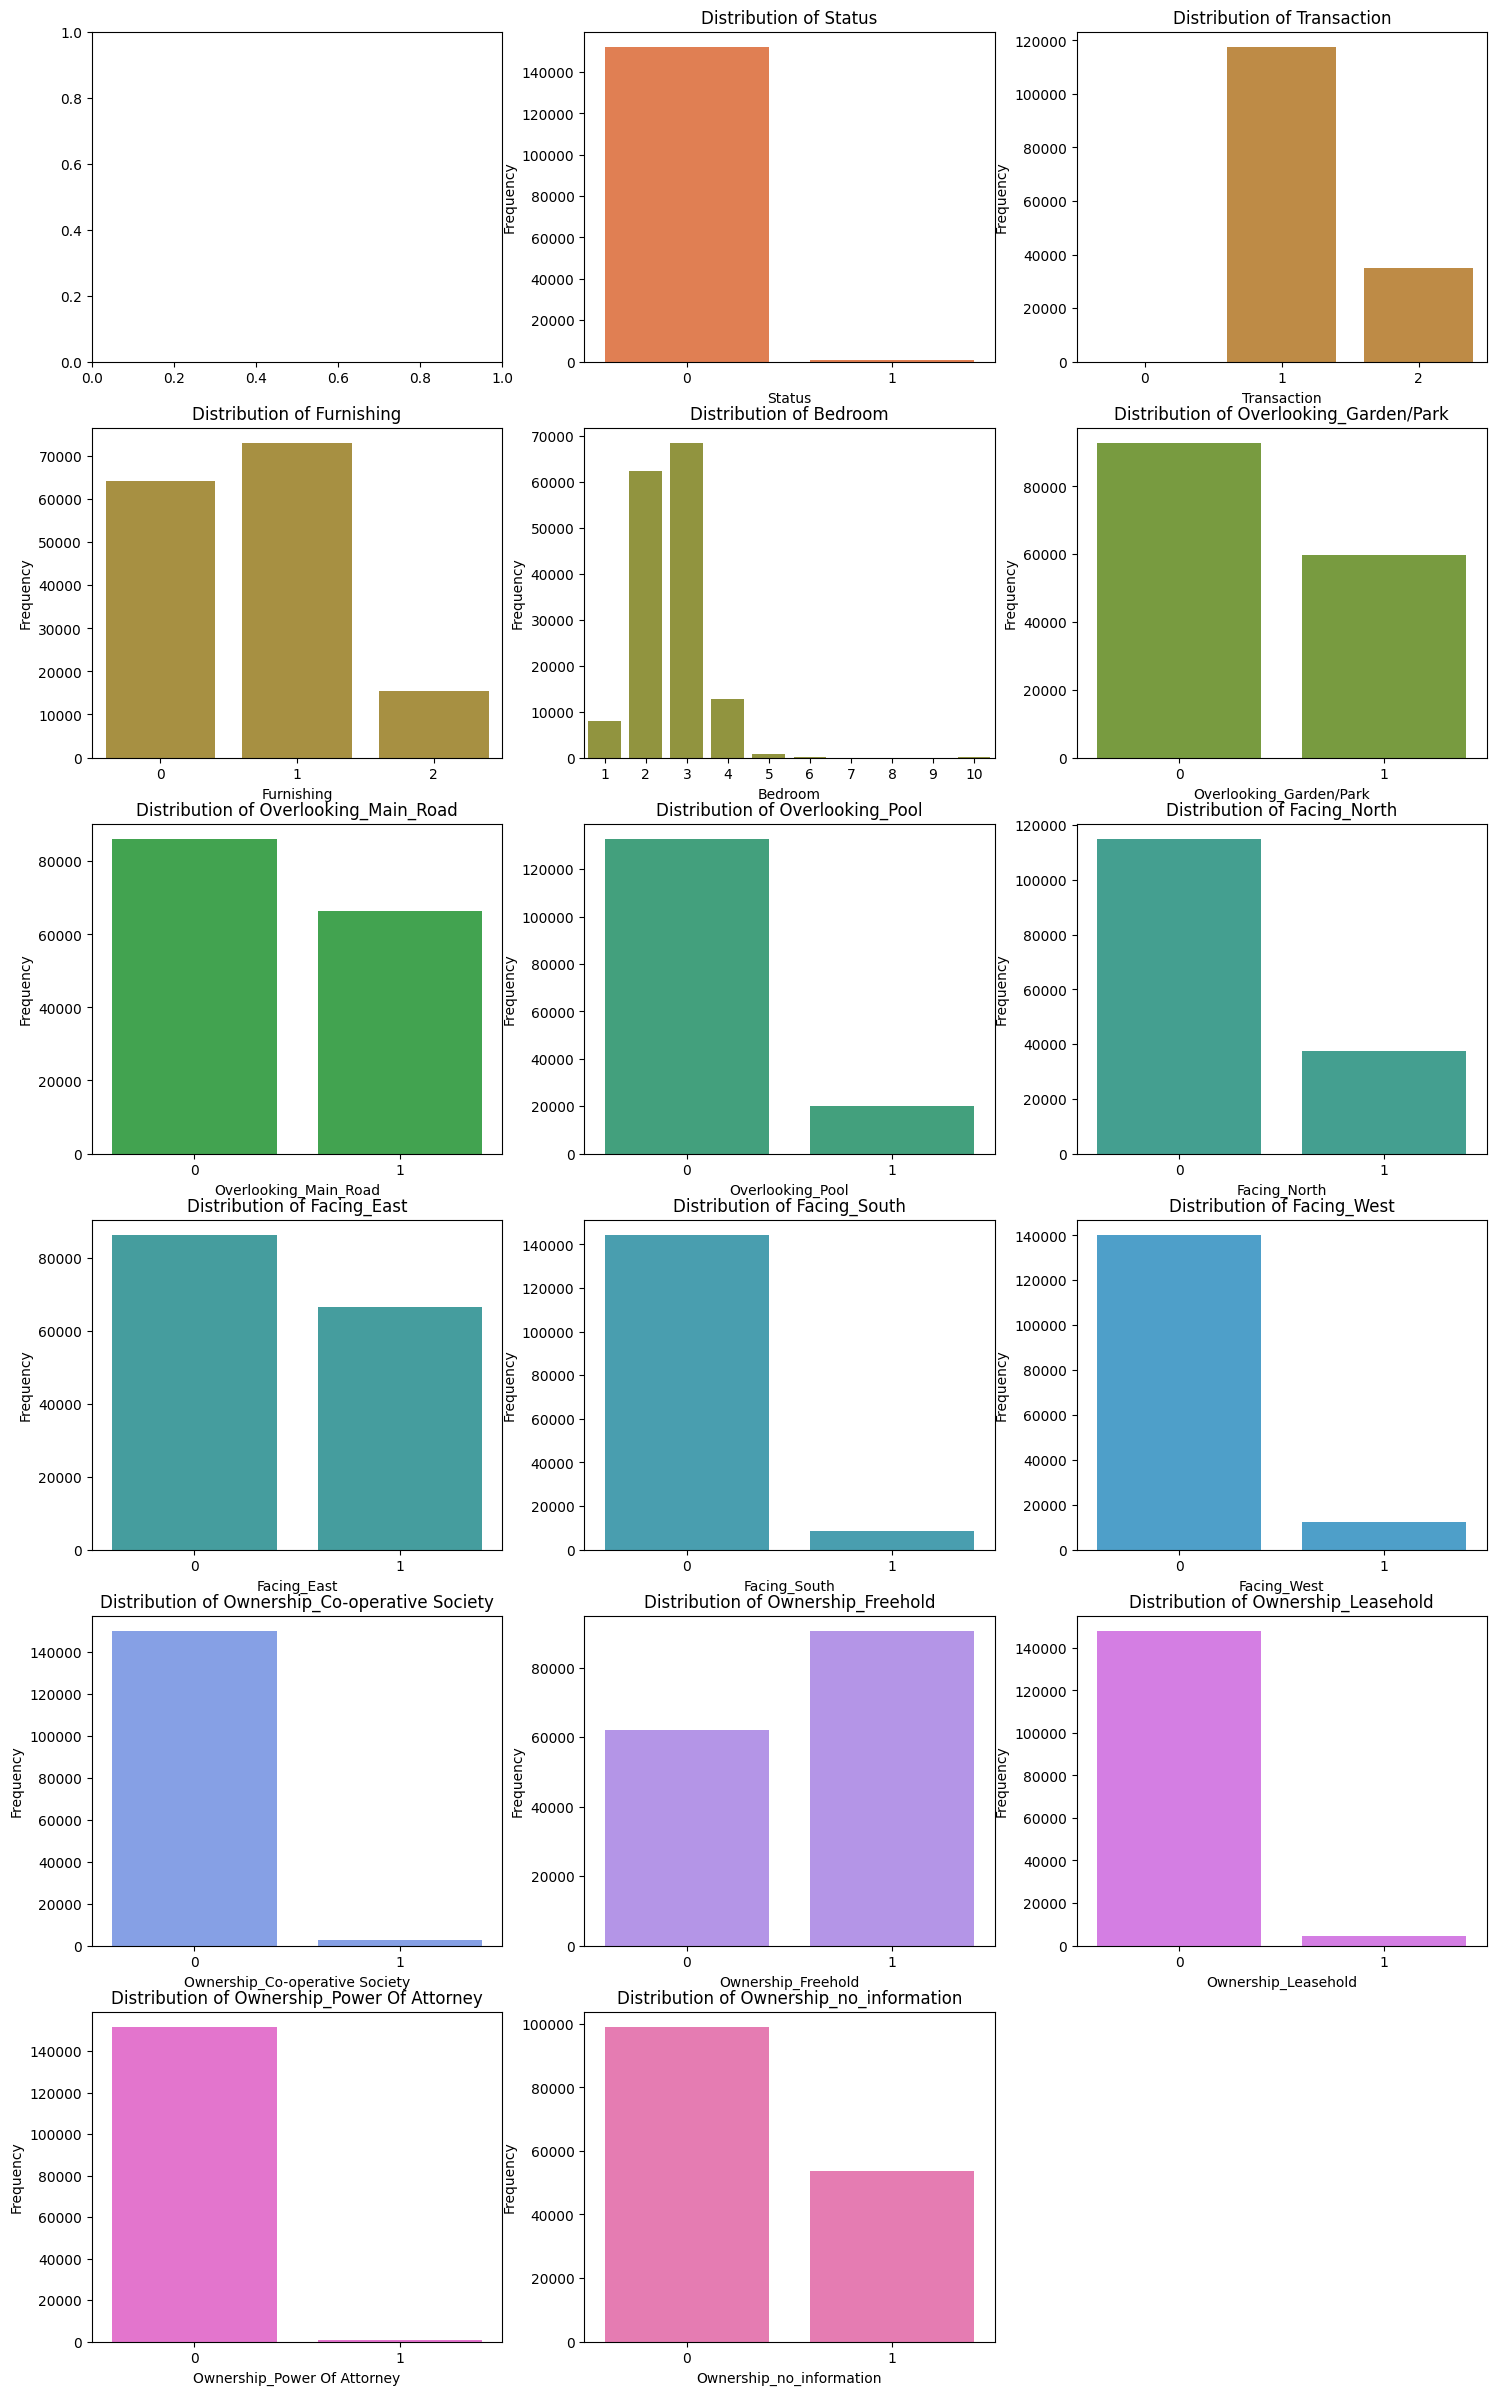

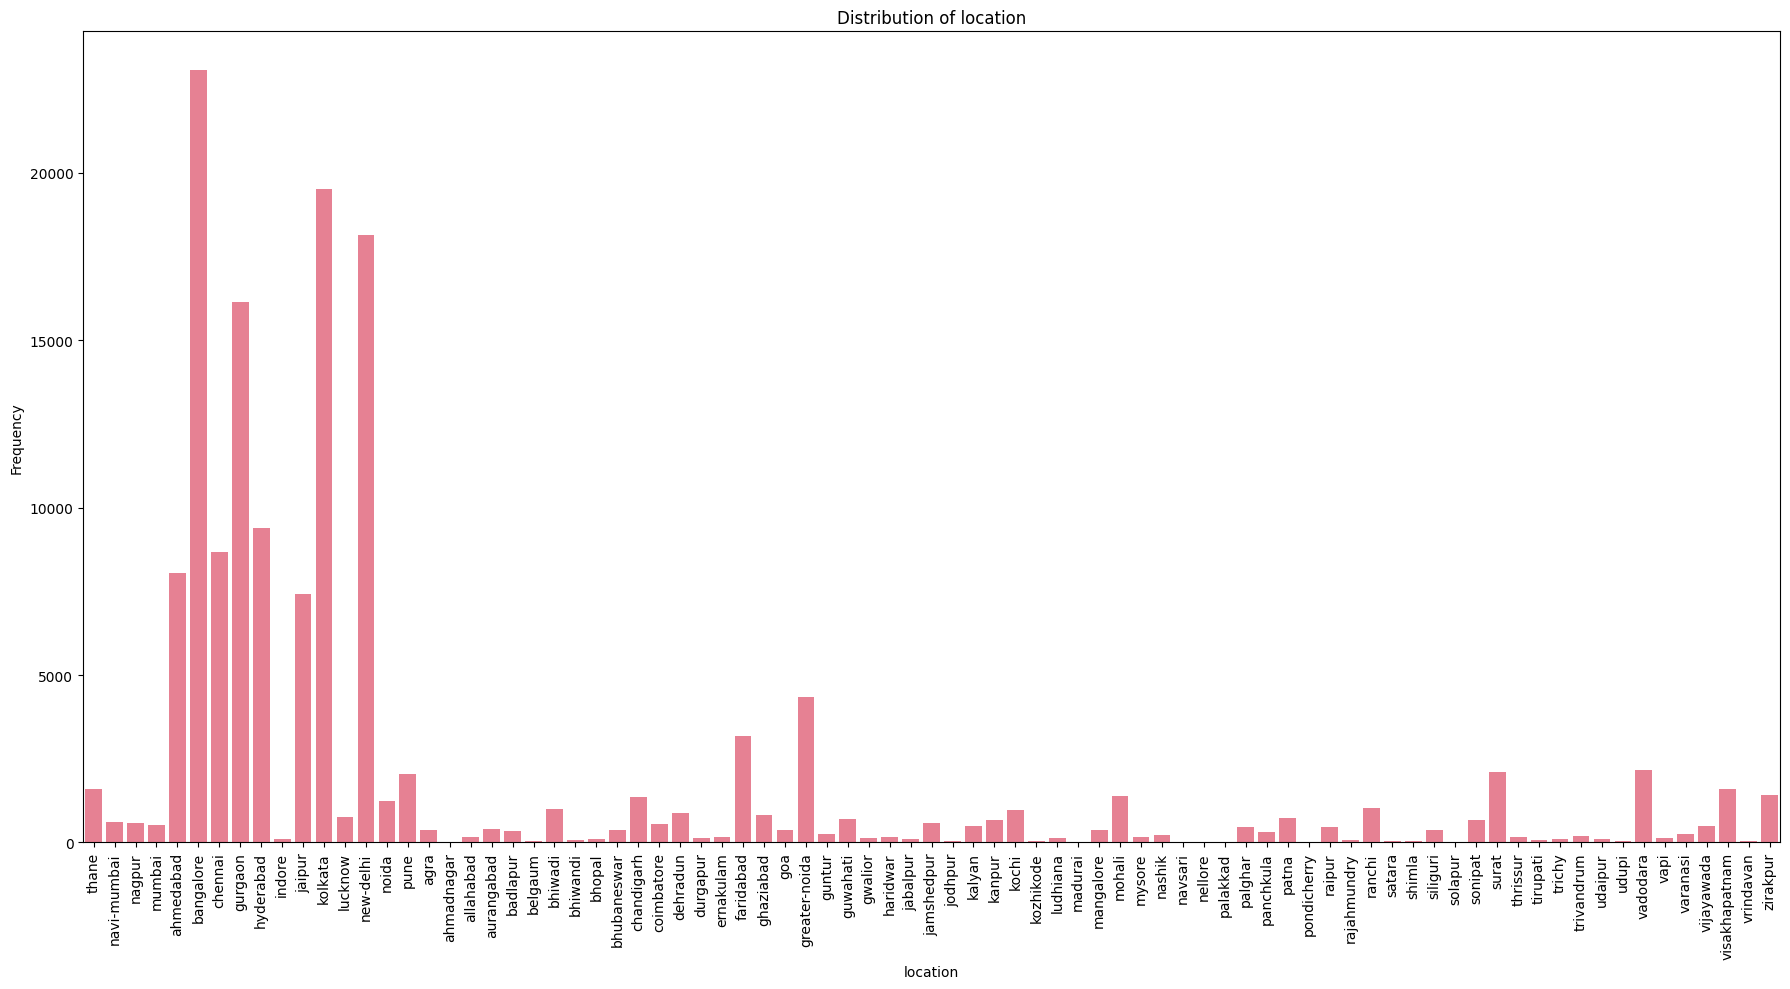

In [14]:
# Plot histograms for categorical features in a matrix
cat_col = len(categorical_columns)
num_rows = (cat_col // 3) + (cat_col % 3 > 0)
fig, axes = plt.subplots(num_rows, 3, figsize=(18, 5 * num_rows))
axes = axes.flatten()

colors = sns.color_palette("husl", cat_col)

for i, column in enumerate(categorical_columns):
    if column == 'location':
        fig_loc, ax_loc = plt.subplots(figsize=(18, 10))  # Increase the size for 'location'
        sns.countplot(data=data, x=column, color=colors[i], ax=ax_loc)
        ax_loc.set_title(f'Distribution of {column}')
        ax_loc.set_xlabel(column)
        ax_loc.set_ylabel('Frequency')
        ax_loc.set_xticklabels(ax_loc.get_xticklabels(), rotation=90)  # Rotate x-axis labels
    else:
        ax = axes[i]
        sns.countplot(data=data, x=column, color=colors[i], ax=ax)
        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## **Hypothesis Tests**

#### **ANOVA** test using **F-Statistic**
#### **Null Hypothesis**: The mean house prices do not differ significantly across different locations.
#### **Alternate Hypothesis**: The mean house prices differ significantly across different locations.

In [15]:
import scipy.stats as stats

# Identify the top 5 most frequent locations
top_locations = data['location'].value_counts().nlargest(5).index

# Filter the data to include only the top 5 locations
filtered_data = data[data['location'].isin(top_locations)]

# Perform ANOVA
anova_result = stats.f_oneway(
    *[filtered_data[filtered_data['location'] == loc]['Price_in_rupees'] for loc in top_locations]
)

print(f"ANOVA result: F-statistic = {anova_result.statistic}, p-value = {anova_result.pvalue}")

# Interpret the result
alpha = 0.05
if anova_result.pvalue < alpha:
    print("Reject the null hypothesis: The mean house prices differ significantly across different locations.")
else:
    print("Fail to reject the null hypothesis: The mean house prices do not differ significantly across different locations.")

ANOVA result: F-statistic = 6118.975967119606, p-value = 0.0
Reject the null hypothesis: The mean house prices differ significantly across different locations.


#### **Karl-Pearson** Correlation Test
#### **Null Hypothesis**: There is no significant linear relationship between carpet area and house prices.
#### **Alternate Hypothesis**: There is a significant linear relationship between carpet area and house prices.

In [16]:
import scipy.stats as stats

# Calculate Pearson correlation coefficient and p-value
correlation, p_value = stats.pearsonr(data['Carpet_area'], data['Price_in_rupees'])

print(f"Pearson correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant linear relationship between carpet area and house prices.")
else:
    print("Fail to reject the null hypothesis: There is no significant linear relationship between carpet area and house prices.")

Pearson correlation coefficient: 0.05421940576005502
P-value: 1.307037136654025e-99
Reject the null hypothesis: There is a significant linear relationship between carpet area and house prices.


In [17]:
# Separate the data into two groups based on furnishing status
furnished_prices = data[data['Furnishing'] == 2]['Price_in_rupees']  # 2 corresponds to 'Furnished'
unfurnished_prices = data[data['Furnishing'] == 0]['Price_in_rupees']  # 0 corresponds to 'Unfurnished'

# Perform independent sample T-test
t_stat, p_value = stats.ttest_ind(furnished_prices, unfurnished_prices, equal_var=False)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Furnished and unfurnished homes have a significant difference in mean house prices.")
else:
    print("Fail to reject the null hypothesis: Furnished and unfurnished homes have no significant difference in mean house prices.")

T-statistic: -12.394012547398315
P-value: 3.5628477131491117e-35
Reject the null hypothesis: Furnished and unfurnished homes have a significant difference in mean house prices.


### **Running ML models**

In [18]:
#label encoding for location
data['location'] = LE.fit_transform(data['location'])

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X=data.drop(columns=['Price_in_rupees'])
X=scaler.fit_transform(X)
y=data['Price_in_rupees']

#splitting the data into training, validation and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")

Training set: (106714, 23), (106714,)


In [50]:
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# Measure training time for each model and collect results
training_times = []

# Model 1: Linear Regression
start_time = time.time()
model = LinearRegression()
model.fit(X_train, y_train)
training_times.append(time.time() - start_time)

# Predictions and scores
lr_val_mse = mean_squared_error(y_val, model.predict(X_val))
lr_test_mse = mean_squared_error(y_test, model.predict(X_test))

# Model 2: Random Forest Regressor
start_time = time.time()
rf_model = RandomForestRegressor(n_estimators=80, random_state=42)
rf_model.fit(X_train, y_train)
training_times.append(time.time() - start_time)

# Predictions and scores
rf_val_mse = mean_squared_error(y_val, rf_model.predict(X_val))
rf_test_mse = mean_squared_error(y_test, rf_model.predict(X_test))

# Model 3: MLP Regressor
start_time = time.time()
mlp_model = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=250, random_state=42)
mlp_model.fit(X_train, y_train)
training_times.append(time.time() - start_time)

# Predictions and scores
mlp_val_mse = mean_squared_error(y_val, mlp_model.predict(X_val))
mlp_test_mse = mean_squared_error(y_test, mlp_model.predict(X_test))

# Combine results for plotting
models = ['Linear Regression', 'Random Forest', 'MLP Regressor']
validation_mses = [lr_val_mse, rf_val_mse, mlp_val_mse]
test_mses = [lr_test_mse, rf_test_mse, mlp_test_mse]



c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


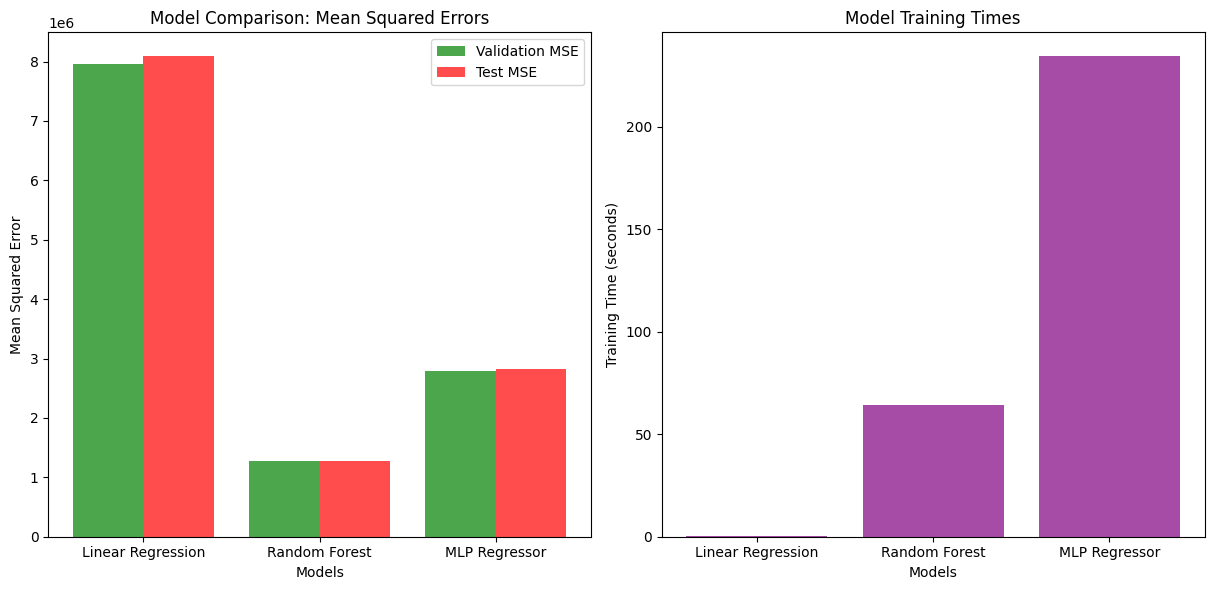

In [51]:
x=range(len(models))

# Plotting
plt.figure(figsize=(18, 6))

# Plot Mean Squared Errors
plt.subplot(1, 3, 2)
plt.bar(x, validation_mses, width=0.4, label='Validation MSE', color='green', alpha=0.7)
plt.bar([i + 0.4 for i in x], test_mses, width=0.4, label='Test MSE', color='red', alpha=0.7)
plt.xticks([i + 0.2 for i in x], models)
plt.title('Model Comparison: Mean Squared Errors')
plt.xlabel('Models')
plt.ylabel('Mean Squared Error')
plt.legend()

# Plot Training Times
plt.subplot(1, 3, 3)
plt.bar(x, training_times, color='purple', alpha=0.7)
plt.xticks(x, models)
plt.title('Model Training Times')
plt.xlabel('Models')
plt.ylabel('Training Time (seconds)')

plt.tight_layout()
plt.show()



## **Scaling techniques**
### **Random Projection**

In [52]:
import time
from sklearn.random_projection import SparseRandomProjection
from sklearn.metrics import mean_squared_error

# Step 1: Initialize Random Projection
n_components = 15  # Set the desired reduced dimension
random_proj = SparseRandomProjection(n_components=n_components, random_state=42)

# Step 2: Apply Random Projection for Dimensionality Reduction
start_time = time.time()

X_train_reduced = random_proj.fit_transform(X_train)
X_val_reduced = random_proj.transform(X_val)
X_test_reduced = random_proj.transform(X_test)

reduction_time = time.time() - start_time

print(f"Dimensionality Reduction Time: {reduction_time:.4f} seconds")

# Step 3: Train a Model on Reduced Data
training_times_reduced = []

# Model 1: Linear Regression
start_time = time.time()
model = LinearRegression()
model.fit(X_train_reduced, y_train)
training_times_reduced.append(time.time() - start_time)

# Predictions and scores
lr_val_mse_reduced = mean_squared_error(y_val, model.predict(X_val_reduced))
lr_test_mse_reduced = mean_squared_error(y_test, model.predict(X_test_reduced))

# Model 2: Random Forest Regressor
start_time = time.time()
rf_model.fit(X_train_reduced, y_train)
training_times_reduced.append(time.time() - start_time)

# Predictions and scores
rf_val_mse_reduced = mean_squared_error(y_val, rf_model.predict(X_val_reduced))
rf_test_mse_reduced = mean_squared_error(y_test, rf_model.predict(X_test_reduced))

# Model 3: MLP Regressor
start_time = time.time()
mlp_model.fit(X_train_reduced, y_train)
training_times_reduced.append(time.time() - start_time)

# Predictions and scores
mlp_val_mse_reduced = mean_squared_error(y_val, mlp_model.predict(X_val_reduced))
mlp_test_mse_reduced = mean_squared_error(y_test, mlp_model.predict(X_test_reduced))

# Combine results for plotting
models = ['Linear Regression', 'Random Forest', 'MLP Regressor']
validation_mses_reduced = [lr_val_mse_reduced, rf_val_mse_reduced, mlp_val_mse_reduced]
test_mses_reduced = [lr_test_mse_reduced, rf_test_mse_reduced, mlp_test_mse_reduced]


Dimensionality Reduction Time: 0.0651 seconds


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


In [53]:

# Print Comparison
print("Model Comparison: Without Dimensionality Reduction")
print("--------------------------------------------------")
for i, model in enumerate(models):
    print(f"{model}: Validation MSE = {validation_mses[i]:.4f}, Test MSE = {test_mses[i]:.4f}")

print("\nModel Comparison: With Dimensionality Reduction")
print("-----------------------------------------------")
for i, model in enumerate(models):
    print(f"{model}: Validation MSE = {validation_mses_reduced[i]:.4f}, Test MSE = {test_mses_reduced[i]:.4f}")

print("\nTraining Times Comparison")
print("-------------------------")
for i, model in enumerate(models):
    print(f"{model}: Without Reduction = {training_times[i]:.4f} seconds, With Reduction = {training_times_reduced[i]:.4f} seconds")


Model Comparison: Without Dimensionality Reduction
--------------------------------------------------
Linear Regression: Validation MSE = 7961746.0960, Test MSE = 8087294.5909
Random Forest: Validation MSE = 1269479.9011, Test MSE = 1281558.2778
MLP Regressor: Validation MSE = 2798100.2339, Test MSE = 2821170.3225

Model Comparison: With Dimensionality Reduction
-----------------------------------------------
Linear Regression: Validation MSE = 8045488.7264, Test MSE = 8150021.8208
Random Forest: Validation MSE = 1870453.6579, Test MSE = 1841607.3673
MLP Regressor: Validation MSE = 3111878.5034, Test MSE = 3118373.2735

Training Times Comparison
-------------------------
Linear Regression: Without Reduction = 0.2670 seconds, With Reduction = 0.0638 seconds
Random Forest: Without Reduction = 64.0997 seconds, With Reduction = 53.3056 seconds
MLP Regressor: Without Reduction = 234.3923 seconds, With Reduction = 122.1239 seconds


In [57]:
import time
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

# Step 1: Initialize PCA for Dimensionality Reduction
n_components = 15  # Set the desired reduced dimension
pca = PCA(n_components=n_components)

# Step 2: Apply PCA for Dimensionality Reduction
start_time = time.time()

X_train_reduced_PCA = pca.fit_transform(X_train)
X_val_reduced_PCA = pca.transform(X_val)
X_test_reduced_PCA = pca.transform(X_test)

reduction_time = time.time() - start_time

print(f"Dimensionality Reduction Time: {reduction_time:.4f} seconds")

# Step 3: Train Models on Reduced Data
training_times_reduced_PCA = []

# Model 1: Linear Regression
start_time = time.time()
model=LinearRegression()
model.fit(X_train_reduced_PCA, y_train)
training_times_reduced_PCA.append(time.time() - start_time)

# Predictions and scores
lr_val_mse_reduced_PCA = mean_squared_error(y_val, model.predict(X_val_reduced_PCA))
lr_test_mse_reduced_PCA = mean_squared_error(y_test, model.predict(X_test_reduced_PCA))

# Model 2: Random Forest Regressor
start_time = time.time()
rf_model.fit(X_train_reduced_PCA, y_train)
training_times_reduced_PCA.append(time.time() - start_time)

# Predictions and scores
rf_val_mse_reduced_PCA = mean_squared_error(y_val, rf_model.predict(X_val_reduced_PCA))
rf_test_mse_reduced_PCA = mean_squared_error(y_test, rf_model.predict(X_test_reduced_PCA))

# Model 3: MLP Regressor
start_time = time.time()
mlp_model.fit(X_train_reduced_PCA, y_train)
training_times_reduced_PCA.append(time.time() - start_time)

# Predictions and scores
mlp_val_mse_reduced_PCA = mean_squared_error(y_val, mlp_model.predict(X_val_reduced_PCA))
mlp_test_mse_reduced_PCA = mean_squared_error(y_test, mlp_model.predict(X_test_reduced_PCA))

# Combine results for plotting
models = ['Linear Regression', 'Random Forest', 'MLP Regressor']
validation_mses_reduced_PCA = [lr_val_mse_reduced_PCA, rf_val_mse_reduced_PCA, mlp_val_mse_reduced_PCA]
test_mses_reduced_PCA = [lr_test_mse_reduced_PCA, rf_test_mse_reduced_PCA, mlp_test_mse_reduced_PCA]


Dimensionality Reduction Time: 0.0295 seconds


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


In [58]:
# Print Comparison
print("Model Comparison: Without Dimensionality Reduction")
print("--------------------------------------------------")
for i, model in enumerate(models):
    print(f"{model}: Validation MSE = {validation_mses[i]:.4f}, Test MSE = {test_mses[i]:.4f}")

print("\nModel Comparison: With Dimensionality Reduction")
print("-----------------------------------------------")
for i, model in enumerate(models):
    print(f"{model}: Validation MSE = {validation_mses_reduced_PCA[i]:.4f}, Test MSE = {test_mses_reduced_PCA[i]:.4f}")

print("\nTraining Times Comparison")
print("-------------------------")
for i, model in enumerate(models):
    print(f"{model}: Without Reduction = {training_times[i]:.4f} seconds, With Reduction = {training_times_reduced_PCA[i]:.4f} seconds")

Model Comparison: Without Dimensionality Reduction
--------------------------------------------------
Linear Regression: Validation MSE = 7961746.0960, Test MSE = 8087294.5909
Random Forest: Validation MSE = 1269479.9011, Test MSE = 1281558.2778
MLP Regressor: Validation MSE = 2798100.2339, Test MSE = 2821170.3225

Model Comparison: With Dimensionality Reduction
-----------------------------------------------
Linear Regression: Validation MSE = 8087517.6890, Test MSE = 8252638.6507
Random Forest: Validation MSE = 2093410.3109, Test MSE = 2052701.2351
MLP Regressor: Validation MSE = 2937445.2501, Test MSE = 3013798.8246

Training Times Comparison
-------------------------
Linear Regression: Without Reduction = 0.2670 seconds, With Reduction = 0.0356 seconds
Random Forest: Without Reduction = 64.0997 seconds, With Reduction = 164.9384 seconds
MLP Regressor: Without Reduction = 234.3923 seconds, With Reduction = 173.9556 seconds
